In [2]:
import pandas as pd

url = "gs://dataproc-staging-us-central1-1084640347746-mwcssbrt/data/a5/selected_vgchartz.csv"
df = pd.read_csv(url)
df.head()

,title,console,genre,critic_score,total_sales,na_sales,jp_sales
0,Grand Theft Auto V,PS3,Action,9.4,20.32,6.37,0.99
1,Grand Theft Auto V,PS4,Action,9.7,19.39,6.06,0.60
2,Grand Theft Auto: Vice City,PS2,Action,9.6,16.15,8.41,0.47
3,Call of Duty: Black Ops 3,PS4,Shooter,8.1,15.09,6.18,0.41
4,Call of Duty: Modern Warfare 3,X360,Shooter,8.7,14.82,9.07,0.13


In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("VGChartz Analysis").getOrCreate()

df_spark = spark.read.option("header", True).csv(url)

from pyspark.sql.functions import col

df_spark = df_spark.withColumn("critic_score", col("critic_score").cast("float")) \
                   .withColumn("total_sales", col("total_sales").cast("float")) \
                   .withColumn("na_sales", col("na_sales").cast("float")) \
                   .withColumn("jp_sales", col("jp_sales").cast("float"))

df_spark = df_spark.dropna()
df_spark.show(5)

25/05/09 08:59:09 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+--------------------+-------+-------+------------+-----------+--------+--------+
|               title|console|  genre|critic_score|total_sales|na_sales|jp_sales|
+--------------------+-------+-------+------------+-----------+--------+--------+
|  Grand Theft Auto V|    PS3| Action|         9.4|      20.32|    6.37|    0.99|
|  Grand Theft Auto V|    PS4| Action|         9.7|      19.39|    6.06|     0.6|
|Grand Theft Auto:...|    PS2| Action|         9.6|      16.15|    8.41|    0.47|
|Call of Duty: Bla...|    PS4|Shooter|         8.1|      15.09|    6.18|    0.41|
|Call of Duty: Mod...|   X360|Shooter|         8.7|      14.82|    9.07|    0.13|
+--------------------+-------+-------+------------+-----------+--------+--------+
only showing top 5 rows



In [4]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

# Use critic_score to predict total_sales
assembler = VectorAssembler(inputCols=["critic_score"], outputCol="features")
data = assembler.transform(df_spark)

lr = LinearRegression(featuresCol="features", labelCol="total_sales")
model = lr.fit(data)

result = model.evaluate(data)
print("R²:", result.r2)
print("Coefficients:", model.coefficients)
print("Intercept:", model.intercept)

25/05/09 08:59:24 WARN Instrumentation: [4e2ab666] regParam is zero, which might cause numerical instability and overfitting.


R²: 0.13492856039246648
Coefficients: [0.6677753109869508]
Intercept: -3.584241026601386


In [5]:
df_plot = df_spark.select("critic_score", "total_sales", "na_sales", "jp_sales").toPandas()
df_plot.to_csv("plot_data.csv", index=False)

print("NA Sales Average:", df["na_sales"].mean())
print("JP Sales Average:", df["jp_sales"].mean())

NA Sales Average: 0.4165810593900482
JP Sales Average: 0.1089586305278174


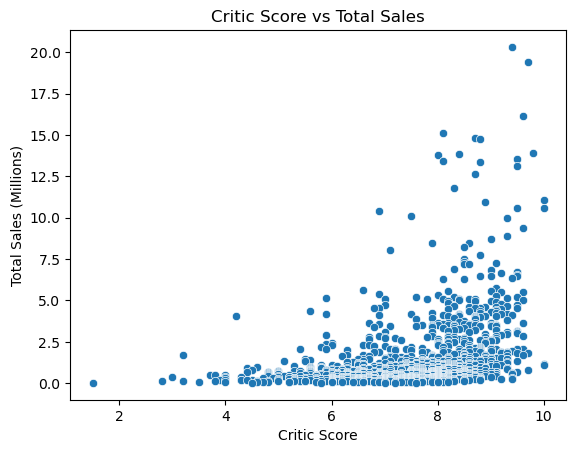

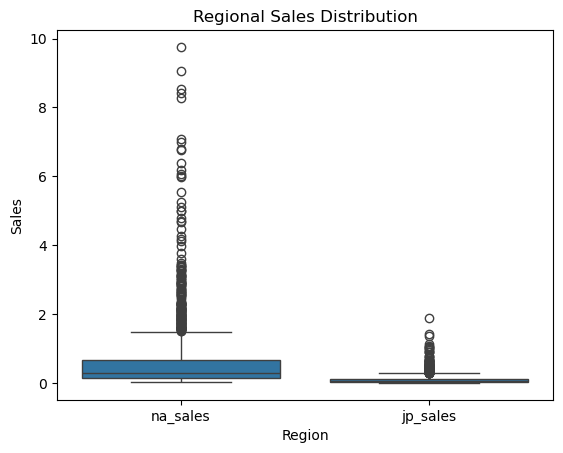

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load for plotting
plot_data = pd.read_csv("plot_data.csv")

# Plot 1: Critic Score vs Total Sales
sns.scatterplot(data=plot_data, x="critic_score", y="total_sales")
plt.title("Critic Score vs Total Sales")
plt.xlabel("Critic Score")
plt.ylabel("Total Sales (Millions)")
plt.savefig("critic_vs_sales.png")
plt.show()

# Plot 2: Box plot of regional sales
melted = plot_data.melt(id_vars="critic_score", value_vars=["na_sales", "jp_sales"], var_name="Region", value_name="Sales")
sns.boxplot(x="Region", y="Sales", data=melted)
plt.title("Regional Sales Distribution")
plt.savefig("regional_sales_boxplot.png")
plt.show()
